# MVA: introduction à Torch distributions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sns
import torch
import torch.distributions as td

Torch distributions allows you to define **probability distributions** as Python objects that you can use for example to


*   sample,
*   compute densities.


# 1. Univariate Gaussian

The most basic distribution is the Gaussian, with density $$p(x | \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-(x-\mu)^2/(2 \sigma^2)}$$.

In [ ]:
mu = 1
sigma = 1

Gaussian = td.Normal(mu, sigma)

In [ ]:
Gaussian.sample() # returns 1 sample

tensor(0.7257)

In [ ]:
Gaussian.sample((2,3)) # returns a 2x3 matrix of iid samples

tensor([[0.5392, 1.1358, 1.0182],
        [0.5023, 0.0049, 2.5360]])

In [ ]:
Gaussian.sample((2,3)).numpy() # returns a 2x3 matrix of iid samples as a numpy array

array([[-0.8313755 ,  2.4714754 ,  1.4708211 ],
       [-0.0464226 , -0.35561907,  0.9399803 ]], dtype=float32)

In [ ]:
Gaussian.mean

tensor(1.)

In [ ]:
Gaussian.mode

tensor(1.)

In [ ]:
Gaussian.variance

tensor(1.)

In [ ]:
x = torch.tensor(3)

Gaussian.log_prob(x) # compute the log  of density of x (useful to compute log-likelihoods!)

tensor(-2.9189)

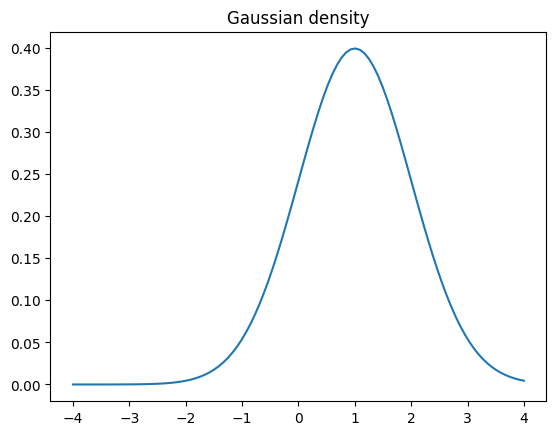

In [ ]:
points = np.linspace(-4,4,100)

plt.plot(points, np.exp(Gaussian.log_prob(torch.tensor(points)).numpy()))
plt.title("Gaussian density")
plt.show()

# 2. More exotic univariate distributions

We can also use discrete distributions, for instance the Poisson distribution, which is a distribution over integers parametrised by a rate $\lambda >0$. For any $x \in \mathbb{N}$, the density is
$$p(x) = \lambda^x e^{-\lambda}/x! $$

In [ ]:
Poisson = td.Poisson(rate=5.6)

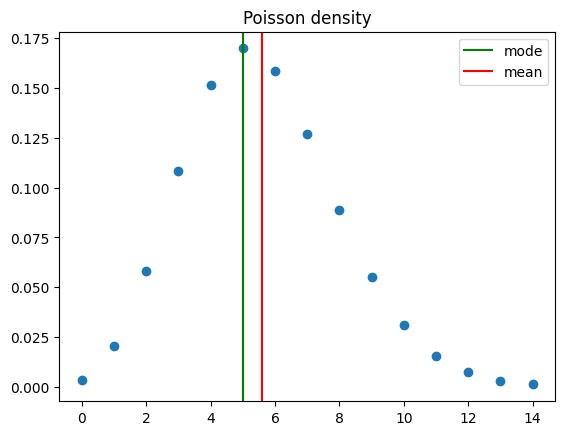

In [ ]:
points = np.arange(0,15)
plt.plot(points, np.exp(Poisson.log_prob(torch.tensor(points)).numpy()), 'o')
plt.axvline(x = Poisson.mode, label = 'mode', color = "green")
plt.axvline(x = Poisson.mean, label = 'mean', color = "red")
# As we can see, when lambda is not an integer, the mean and the mode differ
plt.title("Poisson density")
plt.legend()
plt.show()

The von Mises distribution is a distribution over angles, used for instance to model dihedral angles in molecular biology. Its parameters are a mean $\mu \in [0, 2 \pi)$ and a concentration $\kappa > 0$. For any angle $x \in (0,2 \pi)$, the density is $$p(x| \mu, \kappa) \propto \exp( \kappa \cos(x - \mu)).$$.

In [ ]:
vM = td.VonMises(loc = np.pi/2, concentration = 1)

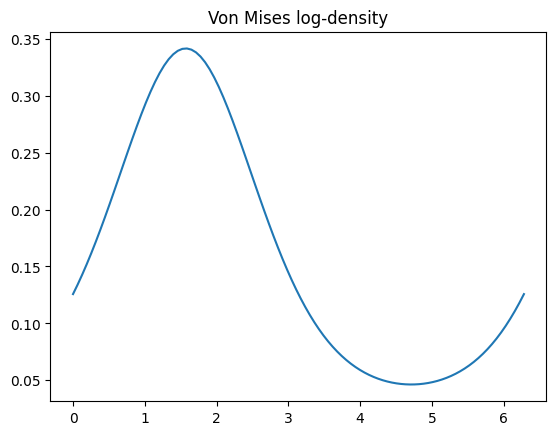

In [ ]:
points = np.linspace(0,2* np.pi,100)
plt.plot(points, np.exp(vM.log_prob(torch.tensor(points)).numpy()))
plt.title("Von Mises log-density")
plt.show()

# 3. Creating several univariate distributions


Often, in machine learning, we have to deal with a lot of similar distributions. For example, if we want to learn a regression model, we want to define $n$ conditional distributions $p(y|\mathbf{x}_1),...,p(y|\mathbf{x}_n)$ with a similar structure.

Feeding a bunch of parameters to the function that creates a distribution allows you to create a bunch of distributions at the same time.

In [ ]:
multiple_Bernoullis = td.Bernoulli(probs=torch.tensor((.3, .5, .7)))
multiple_Bernoullis.sample()

tensor([0., 0., 0.])

If we compute $5$ samples, then we get a $5$ times $3$ matrix:

In [ ]:
multiple_Bernoullis.sample((5,1))

tensor([[[0., 1., 1.]],

        [[1., 0., 1.]],

        [[0., 0., 0.]],

        [[0., 0., 1.]],

        [[1., 0., 1.]]])

Note that `multiple_Bernoullis` is not a multivariate distributions, it's a collection of $3$ univariate distributions! In particular, if we use `log_prob`, we get 3 values, one for each distribution.

In [ ]:
multiple_Bernoullis.log_prob(torch.tensor((0.,0.,1.)))

tensor([-0.3567, -0.6931, -0.3567])

# 4. Creating fully-factorised distributions


As we saw in the lecture, a simple way of creating multivariate distributions is to just multiply univariate distributions. Let's say we have $K$ univariate distributions $p(x_1),...,p(x_K)$. A way to define a distribution over $K$-dimensional vector $\mathbf{x} = (x_1,...,x_K)$ is to consider the product
$$p ( \mathbf{x}) = \prod_{k=1}^K  p(x_k).$$

This means that the coordinates of $\mathbf{x}$ will be **independent**. In graphical modelling terms, this corresponds to a "trivial" graph with no edges.

Using Torch distributions, it's rather easy to define fully factorised distributions, via the function `td.Independent`. The idea is to first define a bunch of distributions (like we saw before), and then combine them.

In [ ]:
prod_multiple_Bernoullis = td.Independent(multiple_Bernoullis, reinterpreted_batch_ndims=1)
prod_multiple_Bernoullis

Independent(Bernoulli(probs: torch.Size([3]), logits: torch.Size([3])), 1)

In [ ]:
prod_multiple_Bernoullis.sample()

tensor([1., 1., 1.])

In [ ]:
prod_multiple_Bernoullis.log_prob(torch.tensor((0.,0.,1.)))

tensor(-1.4065)

To differentiate between collections (aka batches) of distributions and multivariate distributions, one can look at their `event_shape`, that corresponds to the dimensionality of the random variable, and `batch_shape`, that corresponds to the size of the batch.

In [ ]:
multiple_Bernoullis.batch_shape, multiple_Bernoullis.event_shape

(torch.Size([3]), torch.Size([]))

In [ ]:
prod_multiple_Bernoullis.batch_shape, prod_multiple_Bernoullis.event_shape

(torch.Size([]), torch.Size([3]))

# A basic generative model on binary MNIST

We will use Larochelle's static binarisation, that can be loaded using the following cell:

In [ ]:
xtrain = np.loadtxt('http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/binarized_mnist_train.amat',dtype=np.float32).reshape(-1,28, 28,order='C')
xvalid = np.loadtxt('http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/binarized_mnist_valid.amat',dtype=np.float32).reshape(-1,28, 28,order='C')
xtest = np.loadtxt('http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/binarized_mnist_test.amat',dtype=np.float32).reshape(-1,28, 28,order='C')

p = 784
n = xtrain.shape[0]
ntest = xtest.shape[0]

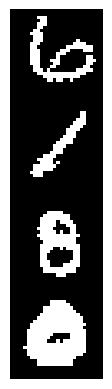

In [ ]:
plt.imshow(xtrain[0:4, :].reshape((-1,28)), cmap='gray')
plt.axis('off')
plt.show()


We build here a **super simple** generative model for the data set. Specifically, the model is simply a product of Bernoulli distributions:
$$p (\textbf{x}) = \prod_{j_1 = 1}^{28}  \prod_{j_2 = 1}^{28} \mathcal{B}(x_{j_1j_2}|\pi_{j_1j_2}).$$

As we saw, the MLE of the parameter is available in closed form, and can be computed in a single line of code.

In [ ]:
pis_hat = torch.tensor(xtrain.mean(0) + 10**(-10)) # I just add 10^-10 to avoid zeros and numerical problems

In [ ]:
prod_of_bernoullis =  td.Independent(td.Bernoulli(probs = pis_hat), reinterpreted_batch_ndims = 2)

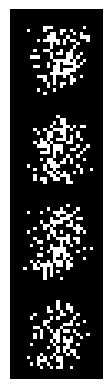

In [ ]:
sample_pofbern = np.reshape(prod_of_bernoullis.sample((4,1)),(-1,28))
plt.imshow(sample_pofbern, cmap='gray')
plt.axis('off')
plt.show()